GSEAPY Example
-----------------------------------------------
Examples to use ``GSEApy`` inside python console

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina' # mac
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

**Check gseapy version**

In [2]:
gp.__version__

'0.9.13'

## 1.  Convert IDs Using Biomart API  

See validated fiters, attributes, datasets  
```python
    >>> from gseapy.parser import Biomart 
    >>> bm = Biomart(verbose=False, host="asia.ensembl.org")
    >>> ## view validated marts
    >>> marts = bm.get_marts()
    >>> ## view validated dataset
    >>> datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
    >>> ## view validated attributes
    >>> attrs = bm.get_attributes(dataset='hsapiens_gene_ensembl') 
    >>> ## view validated filters
    >>> filters = bm.get_filters(dataset='hsapiens_gene_ensembl')
    >>> ## query results
    >>> results = bm.query(dataset='hsapiens_gene_ensembl', attributes=['entrezgene', 'go_id'],
                          filters={'ensemble_gene_id': [your_input_list]})
```

In [3]:
# read in an example gene list
gene_list = pd.read_csv("./data/gene_list.txt",header=None, sep="\t")
gene_list.head()

,0
0,IGKV4-1
1,CD55
2,IGKC
3,PPFIBP1
4,ABHD4


In [4]:
# convert dataframe or series to list
glist = gene_list.squeeze().str.strip().tolist()
print(glist[:10])

['IGKV4-1', 'CD55', 'IGKC', 'PPFIBP1', 'ABHD4', 'PCSK6', 'PGD', 'ARHGDIB', 'ITGB2', 'CARD6']


In [5]:
from gseapy.parser import Biomart

In [6]:
bm = Biomart()

In [7]:
## BioMart is slow. Be patient
results = bm.query(dataset='hsapiens_gene_ensembl', 
                   attributes=['external_gene_name','entrezgene', 'go_id'],
                   filters={'hgnc_symbol': glist}, 
                   # save output file 
                   filename="query.results.txt")

In [8]:
# note: pandas read entrez ids as floats, you need to convert them to int 
results.head()

,external_gene_name,entrezgene,go_id
0,ABAT,18.0,GO:0003824
1,ABAT,18.0,GO:0030170
2,ABAT,18.0,GO:0008483
3,ABAT,18.0,GO:0003867
4,ABAT,18.0,GO:0009448


## 2. Enrichr Example

**See all supported enrichr library names**  

Select database from **{ 'Human', 'Mouse', 'Yeast', 'Fly', 'Fish', 'Worm' }**   

Enrichr library could be used for ``gsea``, ``ssgsea``, and ``prerank``, too

In [9]:
names = gp.get_library_name() # default: Human
names[:10]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_down']

In [10]:
yeast = gp.get_library_name(database='Yeast') 
yeast[:10]

['Cellular_Component_AutoRIF',
 'Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Biological_Process_2018',
 'GO_Biological_Process_AutoRIF',
 'GO_Biological_Process_AutoRIF_Predicted_zscore',
 'GO_Cellular_Component_2018',
 'GO_Cellular_Component_AutoRIF',
 'GO_Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Molecular_Function_2018',
 'GO_Molecular_Function_AutoRIF']

### 2.1  Assign enrichr with ``pd.Series``,  ``pd.DataFrame``, or ``list`` object

#### 2.1.1 gene_sets support list, str.  
Multi-libraries names supported, separate each name by comma or input a list. 

For example:
```python
    # gene_list
    gene_list="./data/gene_list.txt", 
    gene_list=glist
    # gene_sets
    gene_sets='KEGG_2016'  
    gene_sets='KEGG_2016,KEGG_2013'
    gene_sets=['KEGG_2016','KEGG_2013']
```

In [11]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list="./data/gene_list.txt", 
                 # or gene_list=glist
                 description='test_name', 
                 gene_sets=['KEGG_2016','KEGG_2013'], 
                 outdir='test/enrichr_kegg', 
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [12]:
# access results through res2d attr
# obj.res2d only stores the last enrichr result in your input libraries
# obj.results stores all results
enr.results.head(5)

,Adjusted P-value,Combined Score,Gene_set,Genes,Old Adjusted P-value,Old P-value,Overlap,P-value,Term,Z-score
0,7.888667e-11,53.688178,KEGG_2016,LILRA6;ITGB3;LILRA2;LILRA5;PPP3R1;FCGR3B;SIRPA...,2.292723e-07,9.026468e-10,28/132,3.105774e-13,Osteoclast differentiation_Homo sapiens_hsa04380,-1.864151
1,5.448332e-10,46.588613,KEGG_2016,RAB5B;ITGB2;PPP3R1;HLA-DMA;HLA-DMB;FCGR3B;CASP...,9.274793e-07,7.302987e-09,31/178,4.290025e-12,Tuberculosis_Homo sapiens_hsa05152,-1.779908
2,1.366949e-09,41.214733,KEGG_2016,ATP6V1A;RAB5B;ITGB5;ITGB3;ITGB2;HLA-DMA;HLA-DM...,1.513502e-06,1.787601e-08,28/154,1.614506e-11,Phagosome_Homo sapiens_hsa04145,-1.658580
3,1.591672e-07,34.154775,KEGG_2016,TGFB1;PRKCB;IFNGR1;IFNGR2;ITGB2;FOS;MAPK14;HLA...,3.321891e-05,6.539155e-07,17/73,3.133213e-09,Leishmaniasis_Homo sapiens_hsa05140,-1.744263
4,1.395934e-07,33.667700,KEGG_2016,ATP6V1A;ATP6V1G1;ATP6V0B;TGFB1;ITGB2;FOS;ITGAL...,3.321891e-05,5.292880e-07,19/90,2.198322e-09,Rheumatoid arthritis_Homo sapiens_hsa05323,-1.688825


#### 2.1.2 Local mode of GO analysis   
If input a .gmt file or gene_set dict object, enrichr runs local.  
**You have to specify the background genes, if local mode used**

For example:
```python
    gene_sets="./data/genes.gmt",
    gene_sets={'A':['gene1', 'gene2',...],
               'B':['gene2', 'gene4',...],
               ...}
```


In [13]:
enr2 = gp.enrichr(gene_list="./data/gene_list.txt", 
                 # or gene_list=glist
                 description='test_name', 
                 gene_sets="./data/genes.gmt",
                 background='hsapiens_gene_ensembl', # or the number of genes, e.g 20000
                 outdir='test/enrichr_kegg2', 
                 cutoff=0.5, # only used for testing.
                 verbose=True)

2019-05-26 12:12:34,822 User Defined gene sets is given: ./data/genes.gmt
2019-05-26 12:12:34,824 Connecting to Enrichr Server to get latest library names
2019-05-26 12:12:34,849 using all annotated genes with GO_ID as background genes
2019-05-26 12:12:34,858 Background: found 19041 genes
2019-05-26 12:12:34,866 Save file of enrichment results: Job Id:140275387977160
2019-05-26 12:12:35,104 Done.



In [14]:
enr2.results.head(5)

,Adjusted P-value,Gene_set,Genes,Overlap,P-value,Term
0,0.581624,CUSTOM140275387977160,PADI2;HAL;MSRB2;IL1R1;MAP3K5;PCSK6;MBOAT2;IQGAP2,8/139,0.287984,BvA_UpIN_A
1,0.227727,CUSTOM140275387977160,DYSF;SUOX;ST3GAL6;KCTD12;HEBP1;ARHGDIB;SYK;MBN...,11/130,0.032532,BvA_UpIN_B
2,0.581624,CUSTOM140275387977160,MBOAT2,1/12,0.424279,CvA_UpIN_A
3,0.581624,CUSTOM140275387977160,PADI2;HAL;ATP6V1B2;IL1R1;IFNGR2;FXYD6;NMNAT1;A...,16/284,0.210293,DvA_UpIN_A
4,0.581624,CUSTOM140275387977160,DYSF;SIRPA;ST3GAL6;HEBP1;GNB4;FAM198B;TXNDC5;M...,12/236,0.372799,DvA_UpIN_D


#### 2.1.3 Plotting

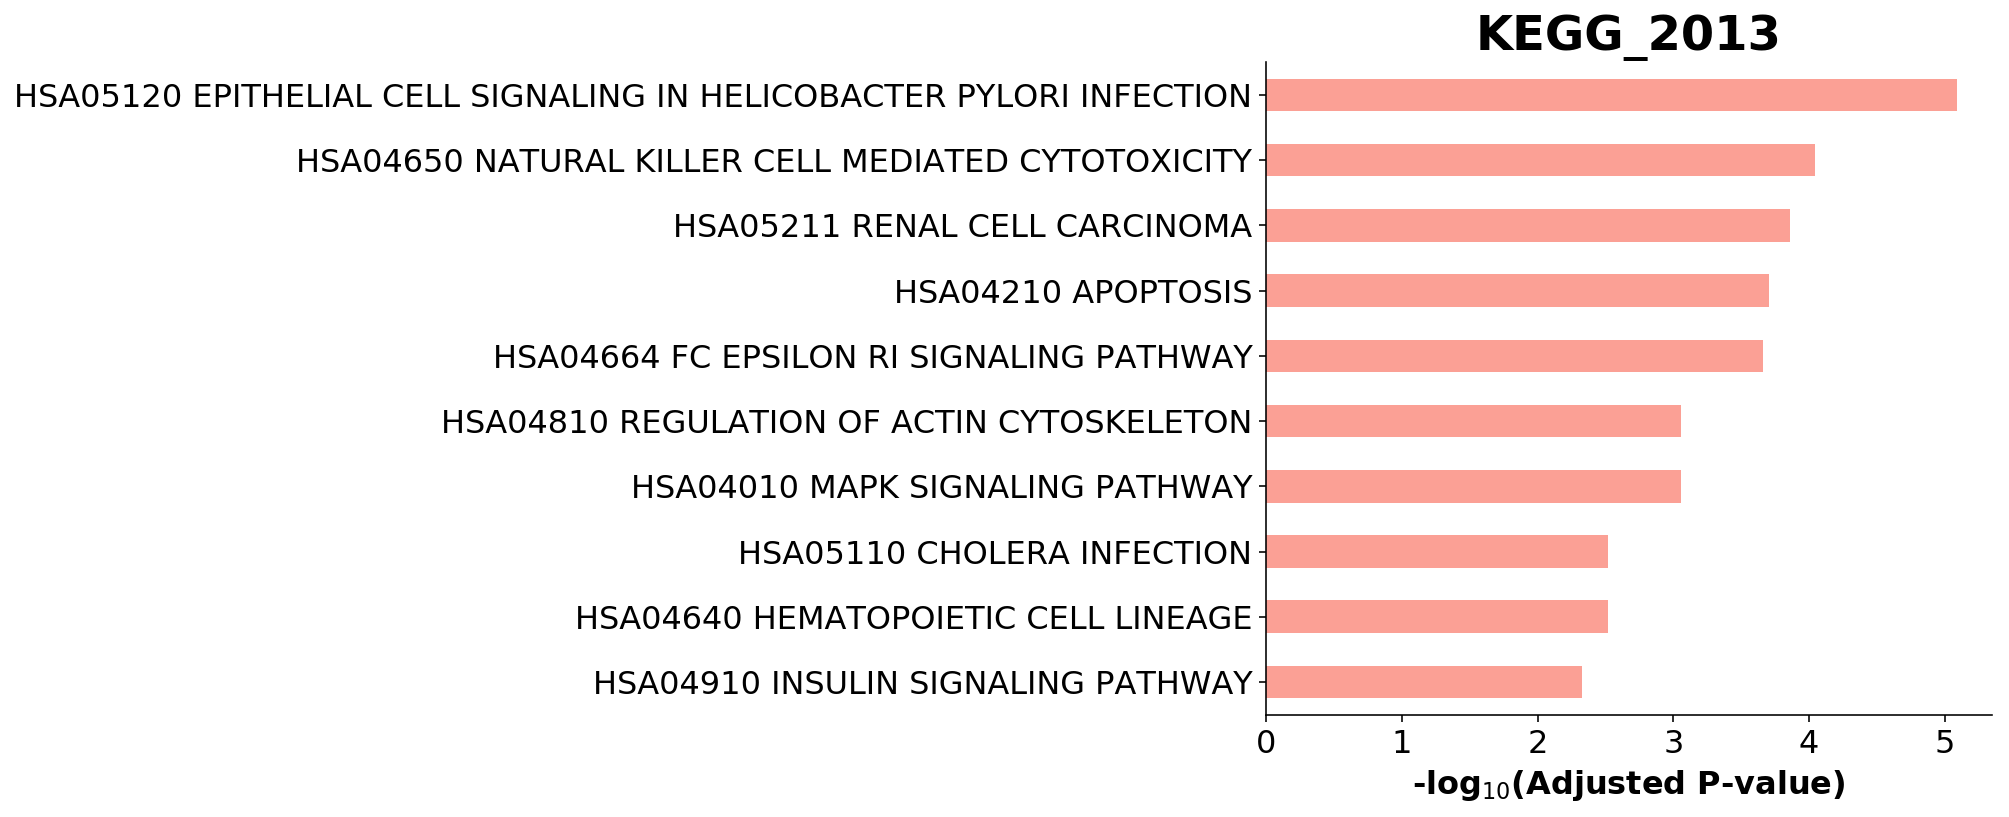

In [15]:
# simple plotting function
from gseapy.plot import barplot, dotplot

# to save your figure, make sure that ``ofname`` is not None
barplot(enr.res2d,title='KEGG_2013',)

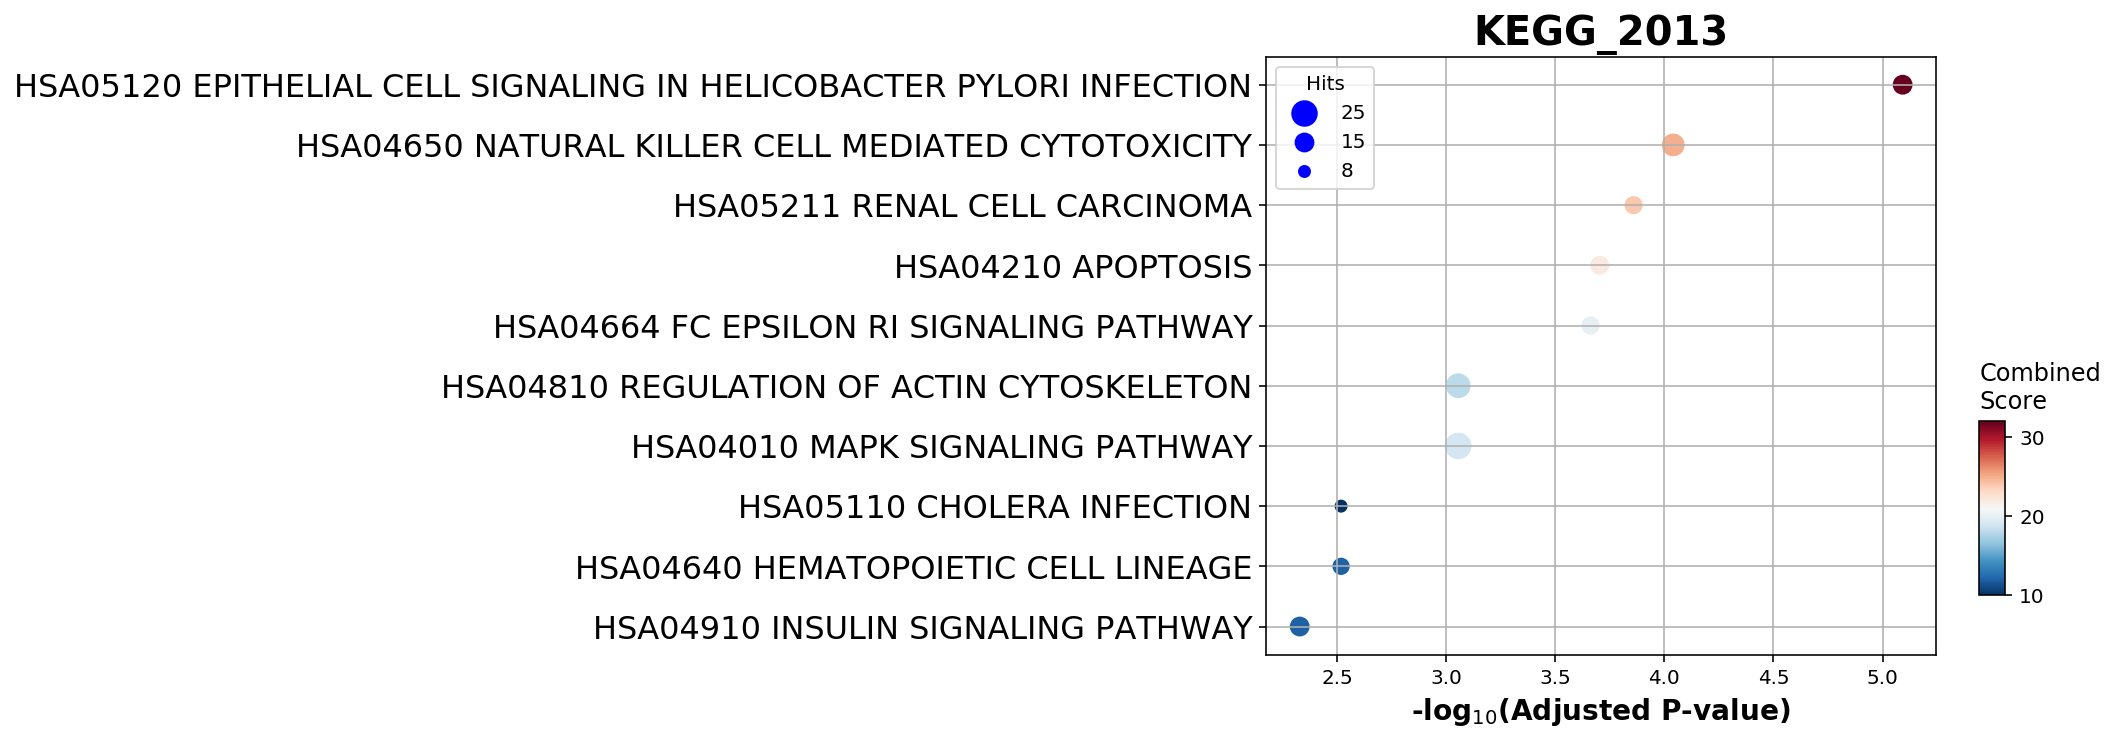

In [16]:
# to save your figure, make sure that ``ofname`` is not None
dotplot(enr.res2d, title='KEGG_2013',)

### 2.2 Command line usage 

You may also want to use enrichr in command line  

the option **-v** will print out the progress of your job

In [17]:
# !gseapy enrichr -i ./data/gene_list.txt \
#                 --ds BP2017 \
#                 -g GO_Biological_Process_2017 \
#                 -v -o test/enrichr_BP

## 3. Prerank example

### 3.1 Assign prerank()  with a pd.DataFrame, pd.Series , or a txt file
Do not include header in your gene list !  
**GSEApy will skip any data after "#".**  
Only contains two columns, or one cloumn with gene_name indexed when assign a ``DataFrame`` to prerank

In [18]:
rnk = pd.read_csv("./data/edb/gsea_data.gsea_data.rnk", header=None, sep="\t")
rnk.head()

,0,1
0,CTLA2B,2.502482
1,SCARA3,2.095578
2,LOC100044683,1.116398
3,CMBL,0.877640
4,CLIC6,0.822181


In [19]:
# run prerank
# enrichr libraries are supported by prerank module. Just provide the name
# use 4 process to acceralate the permutation speed

# note: multiprocessing may not work on windows
pre_res = gp.prerank(rnk=rnk, gene_sets='KEGG_2016', 
                     processes=4,
                     permutation_num=100, # reduce number to speed up testing
                     outdir='test/prerank_report_kegg', format='png')

Leading edge genes save to the final output results

In [20]:
#access results through obj.res2d attribute or obj.results
pre_res.res2d.head()

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Cytokine-cytokine receptor interaction_Homo sapiens_hsa04060,0.418234,2.588945,0.107143,0.210526,265,18,IL13RA1;CSF1;CCL2;TGFBR2;CD40;IL10RB;CXCL10;CX...,IL13RA1;CSF1;CCL2;TGFBR2;CD40;IL10RB;CXCL10
Pathways in cancer_Homo sapiens_hsa05200,-0.188934,-3.526497,0.500000,0.284247,397,27,TGFBR2;LAMB3;RET;PDGFRB;ADCY6;ETS1;TGFA;WNT9A;...,VEGFC;LPAR4;LEF1;RUNX1T1
Rap1 signaling pathway_Homo sapiens_hsa04015,0.221306,1.346911,0.615385,0.752193,211,19,CSF1;EFNA1;ARAP3;PDGFRB;ADCY6;PRKD1;MAPK13;FLT...,CSF1;EFNA1
PI3K-Akt signaling pathway_Homo sapiens_hsa04151,0.191372,1.149349,0.757576,0.813910,341,22,CSF1;EFNA1;COL6A1;THBS4;LAMB3;PDGFRB;GNG13;FLT...,CSF1;EFNA1;COL6A1;THBS4;LAMB3
HTLV-I infection_Homo sapiens_hsa05166,0.338286,1.842641,0.146667,0.848684,258,19,CRTC3;TGFBR2;CD40;PDGFRB;ADCY6;PPP3CC;ETS1;WNT...,CRTC3;TGFBR2;CD40;PDGFRB;ADCY6;PPP3CC;ETS1;WNT...


### 3.2 How to generate your GSEA plot inside python console  
Visualize it using ``gseaplot``  

Make sure that ``ofname`` is not None, if you want to save your figure to the disk

In [21]:
# extract geneset terms in res2d
terms = pre_res.res2d.index
terms

Index(['Cytokine-cytokine receptor interaction_Homo sapiens_hsa04060',
       'Pathways in cancer_Homo sapiens_hsa05200',
       'Rap1 signaling pathway_Homo sapiens_hsa04015',
       'PI3K-Akt signaling pathway_Homo sapiens_hsa04151',
       'HTLV-I infection_Homo sapiens_hsa05166',
       'MAPK signaling pathway_Homo sapiens_hsa04010',
       'Focal adhesion_Homo sapiens_hsa04510',
       'Metabolic pathways_Homo sapiens_hsa01100',
       'Ras signaling pathway_Homo sapiens_hsa04014'],
      dtype='object', name='Term')

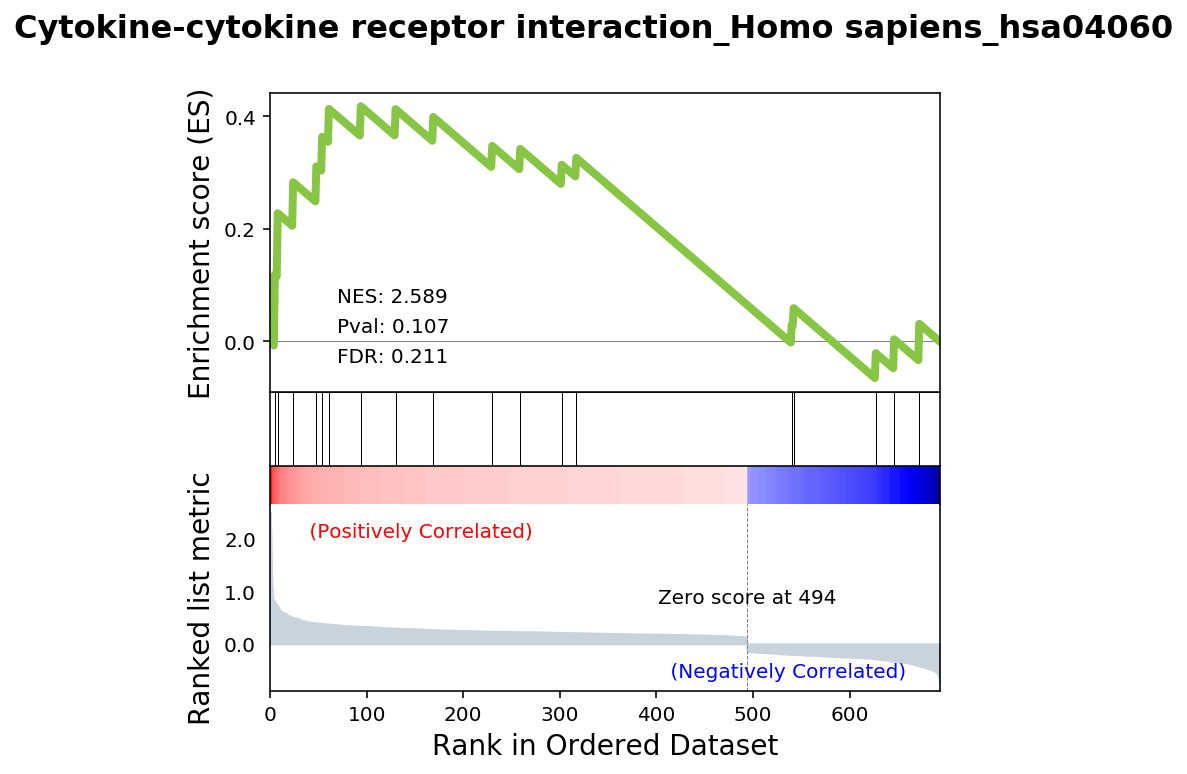

In [22]:
## easy way
from gseapy.plot import gseaplot

# to save your figure, make sure that ofname is not None
gseaplot(rank_metric=pre_res.ranking, term=terms[0], **pre_res.results[terms[0]])

# save figure
# gseaplot(rank_metric=pre_res.ranking, term=terms[0], ofname='your.plot.pdf', **pre_res.results[terms[0]])

### 3) Command line usage 

You may also want to use prerank in command line

In [23]:
# ! gseapy prerank -r temp.rnk -g temp.gmt -o prerank_report_temp

## 4. GSEA Example

### 4.1  Assign gsea() with a pandas DataFrame, .gct format file, or a text file

and cls with a list object or just .cls format file 

In [24]:
phenoA, phenoB, class_vector =  gp.parser.gsea_cls_parser("./data/P53.cls")

In [25]:
#class_vector used to indicate group attributes for each sample
print(class_vector)

['MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT']


In [26]:
gene_exp = pd.read_csv("./data/P53.txt", sep="\t")
gene_exp.head()

,NAME,DESCRIPTION,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
0,TACC2,na,46.05,82.17,16.87,98.60,141.02,114.32,134.34,44.95,...,68.14,32.21,105.89,64.99,53.52,85.47,18.69,32.16,45.70,48.13
1,C14orf132,na,108.34,59.04,25.61,33.11,42.53,9.12,9.36,310.96,...,159.32,10.71,13.59,53.78,57.57,86.80,17.30,102.66,62.16,73.44
2,AGER,na,42.20,25.75,76.01,40.41,32.17,48.28,58.27,42.40,...,51.50,61.48,44.44,45.68,54.17,62.53,83.18,56.57,50.40,36.75
3,32385_at,na,7.43,13.94,8.55,21.13,15.09,19.05,16.47,7.60,...,30.77,21.27,13.36,16.19,12.07,17.62,22.60,4.50,14.59,11.33
4,RBM17,na,11.40,3.00,3.16,2.34,4.43,1.56,6.04,6.16,...,1.62,2.77,4.42,8.91,12.28,3.04,10.13,8.32,8.23,3.91


In [27]:
print("positively correlated: ", phenoA)

positively correlated:  MUT


In [28]:
print("negtively correlated: ", phenoB)

negtively correlated:  WT


In [29]:
# run gsea
# enrichr libraries are supported by gsea module. Just provide the name

gs_res = gp.gsea(data=gene_exp, # or data='./P53_resampling_data.txt'
                 gene_sets='KEGG_2016', # enrichr library names
                 cls= './data/P53.cls', # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype', 
                 permutation_num=100, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 no_plot=True, # Skip plotting
                 method='signal_to_noise',
                 processes=4,
                 format='png')

In [30]:
#access the dataframe results throught res2d attribute
gs_res.res2d.head()

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
N-Glycan biosynthesis_Homo sapiens_hsa00510,0.538433,3.600101,0.052174,0.223501,49,24,DPM2;B4GALT2;GANAB;FUT8;DPM1;MAN1A1;TUSC3;ALG8...,DPM2;B4GALT2;GANAB;FUT8;DPM1;MAN1A1;TUSC3;ALG8...
Calcium signaling pathway_Homo sapiens_hsa04020,-0.376305,-4.227417,0.000000,0.333550,180,144,ADORA2B;PLCE1;PHKA2;GNA11;PPP3CB;PTGFR;ERBB2;C...,GRIN2C;HTR2A;ITPR2;ADCY2;GRIN2A;TBXA2R;SLC8A1;...
Fat digestion and absorption_Homo sapiens_hsa04975,-0.521341,-4.005290,0.028302,0.391059,41,25,DGAT1;PPAP2A;PPAP2C;PPAP2B;ACAT2;AGPAT2;GOT2;F...,APOA1;PLA2G1B;SCARB1;CEL;PNLIPRP1;APOA4;APOB;A...
Rheumatoid arthritis_Homo sapiens_hsa05323,-0.421741,-3.304221,0.044248,0.434478,90,67,IL18;MMP1;MMP3;FOS;CCL2;TCIRG1;TNFRSF11A;HLA-D...,ATP6V0A2;ATP6V1E1;ATP6V1G1;ACP5;ATP6V0D1;HLA-D...
Neuroactive ligand-receptor interaction_Homo sapiens_hsa04080,-0.400530,-3.286234,0.060345,0.435423,277,185,ADORA2B;PRSS2;PTGFR;CNR1;DRD4;P2RY2;PRSS3;GRIA...,GRIN2C;HTR2A;GRIN2A;GRM4;C3AR1;SSTR5;THRB;TBXA...


### 4.2 Show the gsea plots

The **gsea** module will generate heatmap for genes in each gene sets in the backgroud.  
But if you need to do it yourself, use the code below

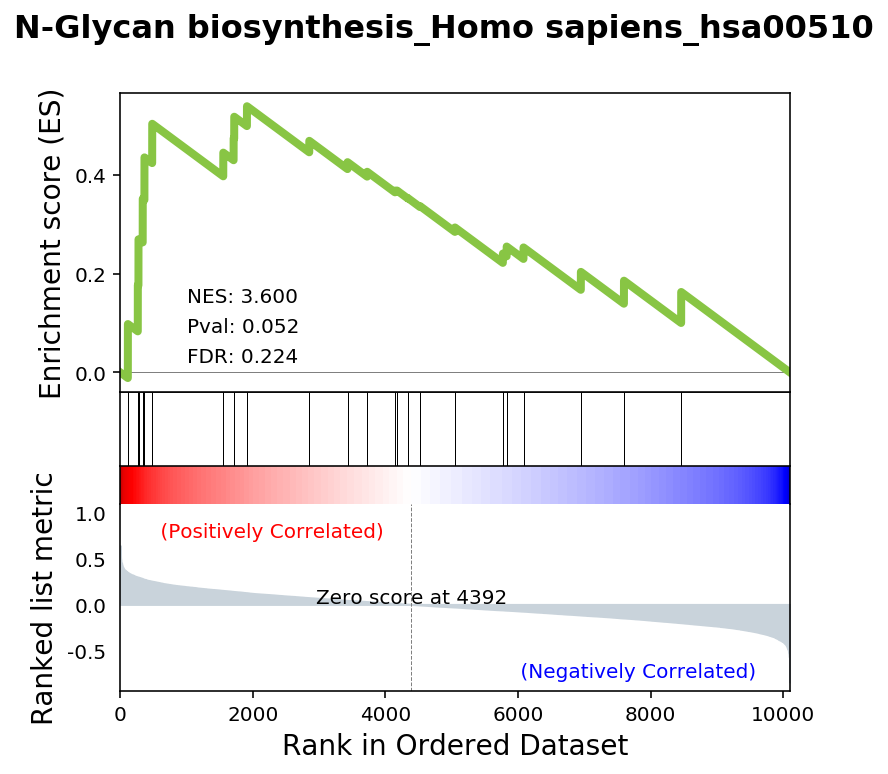

In [31]:
from gseapy.plot import gseaplot, heatmap
terms = gs_res.res2d.index
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
gseaplot(gs_res.ranking, term=terms[0], **gs_res.results[terms[0]])

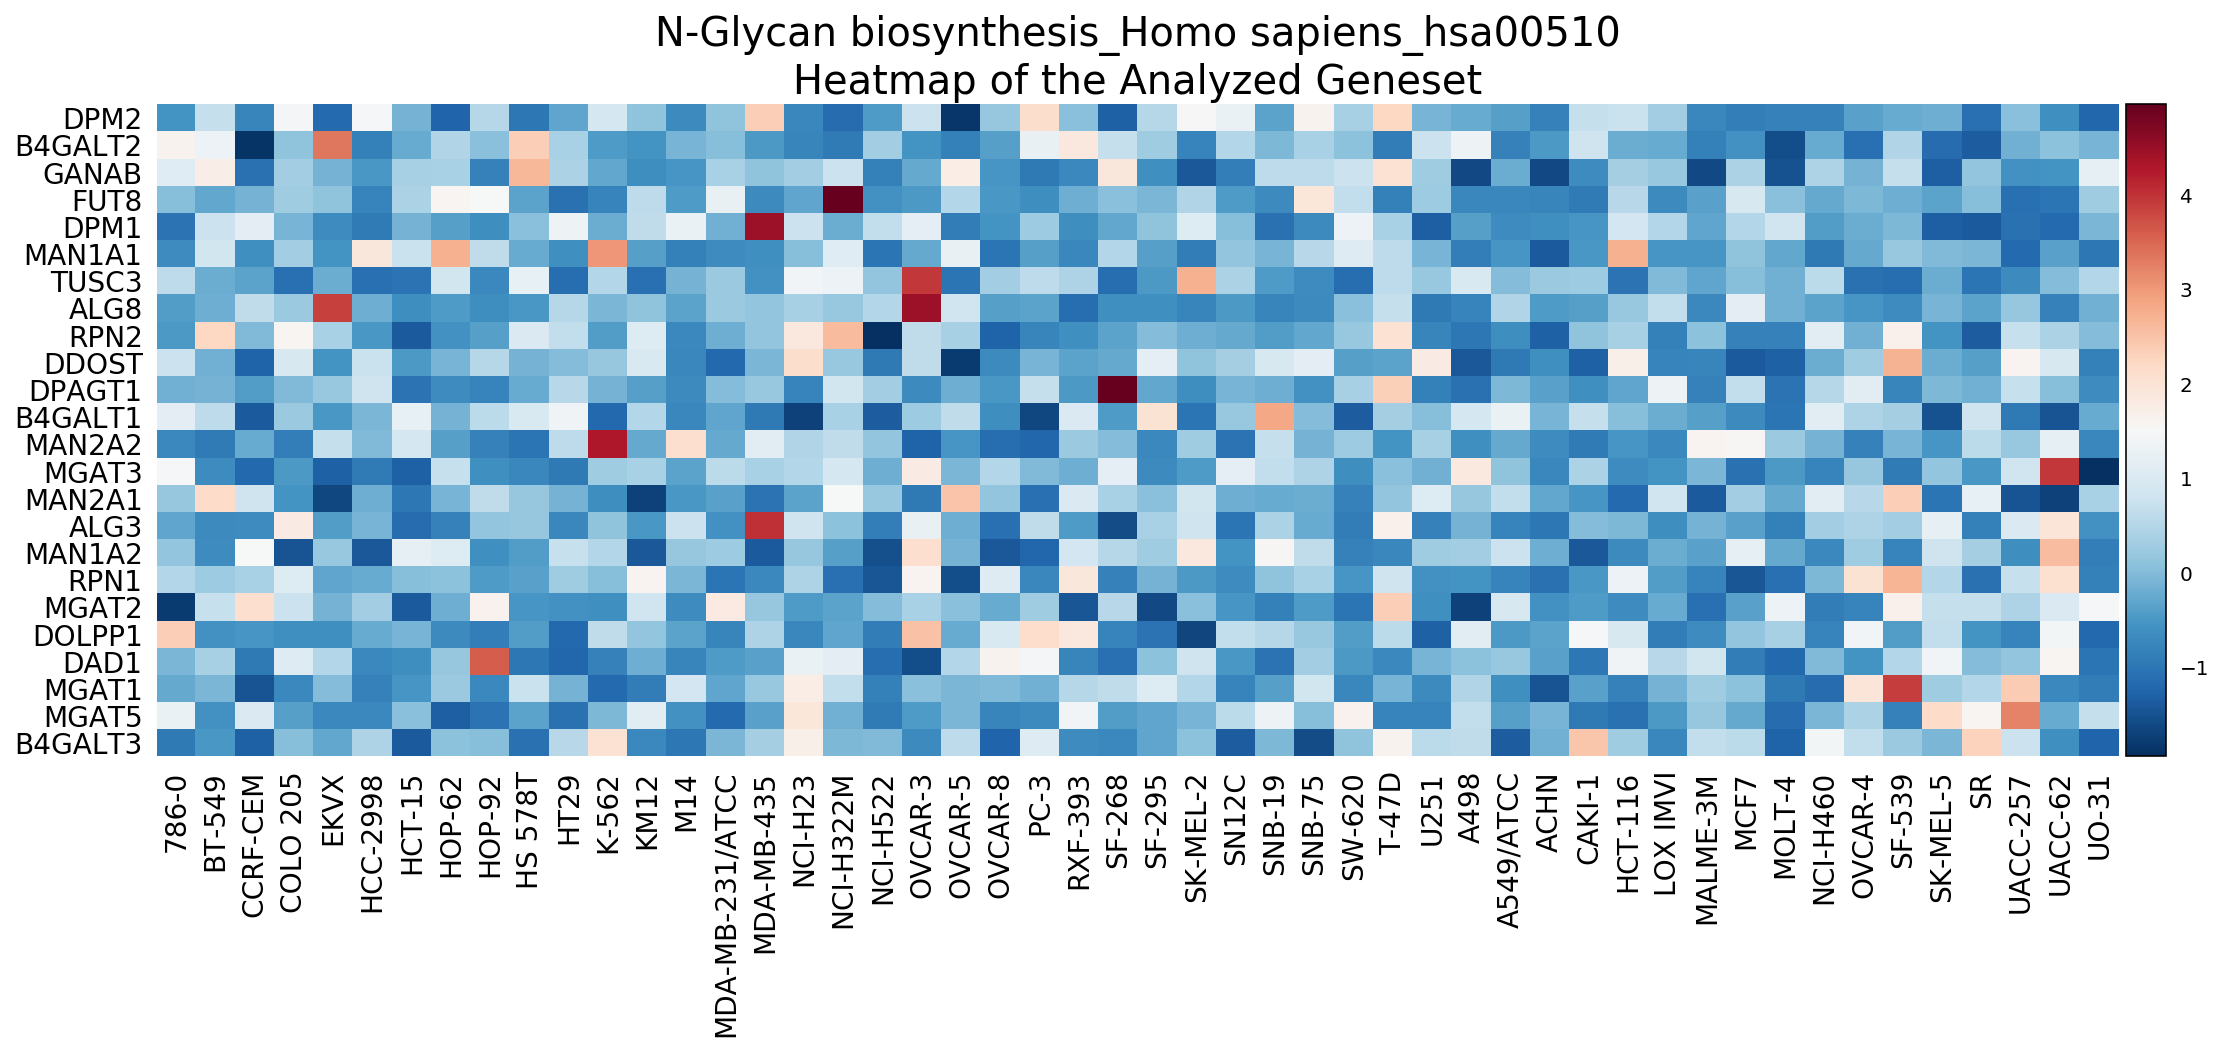

In [32]:
# plotting heatmap
genes = gs_res.res2d.genes[0].split(";")
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
heatmap(df = gs_res.heatmat.loc[genes], z_score=0, title=terms[0], figsize=(18,6))

### 4.3 Command line usage 

You may also want to use gsea in command line

In [33]:
# !gseapy gsea -d ./data/P53_resampling_data.txt \
#              -g KEGG_2016 -c ./data/P53.cls \
#              -o test/gsea_reprot_2 \
#              -v --no-plot \
#              -t phenotype

## 5. Single Sample GSEA example

**Note: When you run ssGSEA, all genes names in your gene_sets file should be found in your expression table**

### 5.1 Input format  
Assign ssgsea() with a txt file, gct file, pd.DataFrame, or pd.Seires(gene name as index)


In [34]:
# txt, gct file input
ss = gp.ssgsea(data="./data/testSet_rand1200.gct",
               gene_sets="./data/randomSets.gmt", 
               outdir='test/ssgsea_report', 
               sample_norm_method='rank', # choose 'custom' for your own rank list
               permutation_num=0, # skip permutation procedure, because you don't need it
               no_plot=True, # skip plotting, because you don't need these figures
               processes=4, format='png')

In [35]:
ss.res2d

,AA488_A1.2,AA489_A2.2,AA490_A3,AA491_B1,AA492_B2,AA493_B3,AA494_C1.2,AA495_C2,AA496_C3,AA497_D1.2,AA498_D3.2,AA499_D2,AA500_x2,AA501_X3,AA502_X2.2,AA503_Y1,AA504_Y2,AA505_Y3
Term|NES,,,,,,,,,,,,,,,,,,
level10_RAND,0.409675,0.412178,0.402321,0.420735,0.423723,0.399593,0.417449,0.426562,0.414945,0.427697,0.428861,0.439795,0.439169,0.429886,0.421071,0.433796,0.436511,0.427593
level12_random,0.623442,0.637662,0.624727,0.636428,0.644896,0.628848,0.645327,0.633330,0.637862,0.647586,0.648293,0.638572,0.652058,0.650088,0.653153,0.660680,0.659886,0.648956
level2_rand,-0.271914,-0.281744,-0.271358,-0.277807,-0.279207,-0.260003,-0.294843,-0.289941,-0.286516,-0.294068,-0.285716,-0.286194,-0.335032,-0.331248,-0.337686,-0.336926,-0.334273,-0.339320
level4_rand,-0.061550,-0.090115,-0.063876,-0.094134,-0.094397,-0.053017,-0.096070,-0.081046,-0.080501,-0.092273,-0.092036,-0.078247,-0.119548,-0.120003,-0.129959,-0.143212,-0.138202,-0.126784
level6_rand,-0.061075,-0.054566,-0.061283,-0.052871,-0.054915,-0.047231,-0.059001,-0.069959,-0.061611,-0.055635,-0.058775,-0.062907,-0.020677,-0.017325,-0.011440,-0.018986,-0.017288,-0.009031
level8_rand,0.145081,0.157404,0.165249,0.160468,0.141703,0.172145,0.139912,0.173172,0.153195,0.146414,0.127259,0.165137,0.175863,0.166732,0.175394,0.166237,0.169276,0.192095
random1,0.154009,0.151312,0.151478,0.147901,0.151960,0.140935,0.154359,0.157054,0.152341,0.150122,0.147418,0.157688,0.125304,0.117738,0.109891,0.113501,0.115591,0.110315
random2,0.114789,0.111621,0.101720,0.112612,0.113221,0.106218,0.120733,0.131228,0.113305,0.125728,0.118026,0.139158,0.090622,0.084933,0.083598,0.080412,0.087921,0.100607
random3,0.090674,0.103528,0.101386,0.099922,0.101013,0.098896,0.095853,0.080370,0.100862,0.089775,0.098816,0.088680,0.098413,0.107809,0.099561,0.103815,0.105186,0.098073


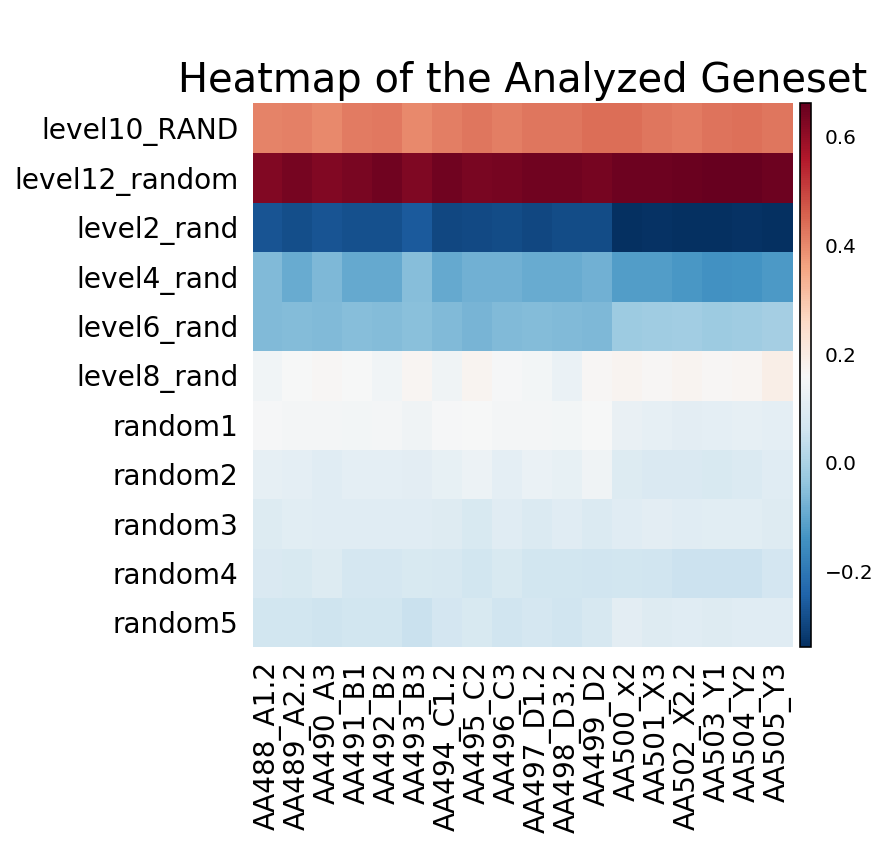

In [36]:
from gseapy.plot import heatmap
heatmap(ss.res2d)

In [37]:
# or assign a dataframe, or Series to ssgsea()
ssdf = pd.read_csv("./data/temp.txt", header=None, sep="\t")
ssdf.head()

,0,1
0,ATXN1,16.456753
1,UBQLN4,13.989493
2,CALM1,13.745533
3,DLG4,12.796588
4,MRE11A,12.787631


In [38]:
# dataframe with one column is also supported by ssGSEA or Prerank
# But you have to set gene_names as index
ssdf2 = ssdf.set_index(0)
ssdf2.head()

,1
0,
ATXN1,16.456753
UBQLN4,13.989493
CALM1,13.745533
DLG4,12.796588
MRE11A,12.787631


In [39]:
type(ssdf2)

pandas.core.frame.DataFrame

In [40]:
ssSeries = ssdf2.squeeze()
type(ssSeries)

pandas.core.series.Series

In [41]:
# reuse data
df = pd.read_csv("./data/P53_resampling_data.txt", sep="\t")
df.head()

,NAME,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
0,CTLA2B,111.19,86.22,121.85,75.19,208.62,130.59,124.72,324.09,242.71,...,163.76,59.50,134.12,152.09,197.46,137.79,81.53,123.37,81.41,180.78
1,SCARA3,460.30,558.34,183.55,37.29,158.00,43.61,80.83,300.08,1250.25,...,109.91,120.42,73.06,115.03,95.12,37.56,76.16,41.10,77.51,519.17
2,LOC100044683,97.25,118.94,81.17,119.51,119.88,107.73,165.57,203.97,135.43,...,222.84,124.98,114.75,141.66,170.19,147.70,157.48,152.18,98.89,118.06
3,CMBL,33.45,55.10,221.67,50.30,35.12,75.70,84.01,44.12,79.96,...,51.32,117.11,59.46,78.46,45.55,49.07,96.69,33.09,10.38,52.89
4,CLIC6,35.75,41.26,63.04,219.86,42.53,54.19,86.98,71.20,53.89,...,154.05,31.62,37.66,32.64,63.35,27.95,70.99,36.25,17.50,49.41


In [42]:
# Series, DataFrame Example
# supports dataframe and series
ssgs = []
for i, dat in enumerate([ssdf, ssdf2, ssSeries, df]):
    sstemp = gp.ssgsea(data=dat, 
                       gene_sets="./data/genes.gmt", 
                       outdir='test/ssgsea_report_'+str(i),
                       scale=False, # set scale to False to get real original ES
                       permutation_num=0, # skip permutation procedure, because you don't need it
                       no_plot=True, # skip plotting, because you don't need these figures
                       processes=4, 
                       format='png')
    ssgs.append(sstemp)

2019-05-26 12:12:57,033 Warning: dropping duplicated gene names, only keep the first values


### 5.2 Access Enrichment Score (ES) and NES

results save to two attribute:

1. obj.resultsOnSamples: ES
2. obj.res2d: NES

In [43]:
# normalized es save to res2d attri
# one sample input
# NES
ssgs[0].res2d.head()

,1
Term|NES,
BvA_UpIN_A,2.150114
BvA_UpIN_B,2.953848
DvA_UpIN_A,1.985451
DvA_UpIN_D,2.457489
YvX_UpIN_X,2.148816


**Note**: 
If you want to obtain the real original enrichment score,  
you have to set ``scale=False``

In [44]:
# ES
# convert dict to DataFrame
es = pd.DataFrame(ssgs[-1].resultsOnSamples)
es.head()

,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,HS 578T,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
Term|ES,,,,,,,,,,,,,,,,,,,,,
BvA_UpIN_B,19.826225,68.077601,127.025106,53.618132,51.205653,21.285201,79.380375,51.496277,38.784929,64.373380,...,49.903306,100.444246,59.520973,59.090405,61.839421,37.801029,61.567375,24.239317,40.271419,46.221578
DvA_UpIN_A,37.106732,16.102699,10.056191,16.232475,32.951477,8.473519,-0.549080,21.782343,21.595246,40.755753,...,8.977915,11.086783,42.961615,49.893513,22.867080,30.443848,11.434225,53.935011,60.430223,44.753762
DvA_UpIN_D,71.124111,84.634416,77.987009,55.918679,72.498150,60.698712,42.545929,59.307949,72.721958,81.539346,...,68.626778,71.937189,89.658150,95.724196,76.479274,68.035031,59.802289,78.330877,73.898535,76.820769


In [45]:
# if set scale to True, then 
# Scaled ES equal to es/gene_numbers
ses = es/df.shape[0]
ses

,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,HS 578T,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
Term|ES,,,,,,,,,,,,,,,,,,,,,
BvA_UpIN_B,0.028568,0.098095,0.183033,0.077260,0.073783,0.030670,0.114381,0.074202,0.055886,0.092757,...,0.071907,0.144732,0.085765,0.085145,0.089106,0.054468,0.088714,0.034927,0.058028,0.066602
DvA_UpIN_A,0.053468,0.023203,0.014490,0.023390,0.047481,0.012210,-0.000791,0.031387,0.031117,0.058726,...,0.012936,0.015975,0.061904,0.071893,0.032950,0.043867,0.016476,0.077716,0.087075,0.064487
DvA_UpIN_D,0.102484,0.121952,0.112373,0.080574,0.104464,0.087462,0.061305,0.085458,0.104787,0.117492,...,0.098886,0.103656,0.129190,0.137931,0.110201,0.098033,0.086170,0.112869,0.106482,0.110693


In [46]:
# NES 
# scale or no have no affects on final nes value
nes = ssgs[-1].res2d
nes.head()

,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,HS 578T,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
Term|NES,,,,,,,,,,,,,,,,,,,,,
BvA_UpIN_B,0.132580,0.455243,0.849433,0.358551,0.342419,0.142337,0.530826,0.344362,0.259360,0.430473,...,0.333710,0.671683,0.398024,0.395145,0.413528,0.252780,0.411709,0.162091,0.269300,0.309089
DvA_UpIN_A,0.248137,0.107681,0.067247,0.108549,0.220351,0.056663,-0.003672,0.145661,0.144410,0.272539,...,0.060036,0.074139,0.287290,0.333644,0.152915,0.203582,0.076462,0.360670,0.404104,0.299274
DvA_UpIN_D,0.475616,0.565961,0.521509,0.373935,0.484804,0.405900,0.284510,0.396600,0.486301,0.545264,...,0.458916,0.481053,0.599555,0.640120,0.511426,0.454959,0.399905,0.523808,0.494169,0.513710


### 3) command line usage of single sample gsea

In [47]:
# set --no-scale to obtain the real original enrichment score
# !gseapy ssgsea -d ./data/testSet_rand1200.gct \
#                -g data/temp.gmt \
#                -o test/ssgsea_report2  \
#                -p 4 --no-plot --no-scale

## 6. Replot Example

### 6.1 locate your directory

notes: ``replot`` module need to find edb folder to work properly.
keep the file tree like this:
```
data
 |--- edb
 |    |--- C1OE.cls
 |    |--- gene_sets.gmt
 |    |--- gsea_data.gsea_data.rnk
 |    |--- results.edb

```

In [48]:
# run command inside python console
rep = gp.replot(indir="./data", outdir="test/replot_test")

### 6.2 command line usage of replot

In [49]:
# !gseapy replot -i data -o test/replot_test